A dental disease recognition system based off of the YOLOv6 model

In [ ]:
%pip install -r requirements.txt

In [30]:
# imports
from torchvision import datasets, transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from sklearn.metrics import classification_report
from PIL import Image
from IPython.display import display
import os
import cv2
# from cnn import CNN
import matplotlib
matplotlib.use("Agg")

# global variables
DATASET_PATH = 'dataset'  # the directory that the dataset files are
IMAGE_DIM = 32  # the dimension of all the images is 32 x 32
IMAGE_CHANNELS = 3  # each image is RGB so has 3 channels
NO_OF_CLASSES = 10  # there are 10 classes of images in the dataset
YOLO_MODEL_FILE = "YOLOModel"
YOLO_MODEL_TRAIN_HISTORY_FILE = "YOLOTrainingHistory"
# define training hyperparameters
BATCH_SIZE = 128
EPOCHS = 9

# image and label directorys
IMAGE_DIR = "data\\dental_dataset\\images"
LABEL_DIR = "data\\dental_dataset\\labels"

# define the train, val and test splits
TRAIN_SPLIT = 0.90
VAL_SPLIT = 0.10
TEST_SPLIT = 0

First is to make the changes to the dataset. Split into train, validation and testing sets

In [3]:
# split image paths and preserve label associations
if(not (os.path.exists(IMAGE_DIR+"/train") & os.path.exists(IMAGE_DIR+"/test") & os.path.exists(IMAGE_DIR+"/val") & os.path.exists(LABEL_DIR+"/train") & os.path.exists(LABEL_DIR+"/test") & os.path.exists(LABEL_DIR+"/val"))):
    image_paths = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)]
    label_paths = [os.path.join(LABEL_DIR, f) for f in os.listdir(LABEL_DIR)]

    image_paths_train, image_paths_val = train_test_split(image_paths, train_size=TRAIN_SPLIT)
    # image_paths_val, image_paths_test = train_test_split(image_paths_temp, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT))
    image_paths_test = []

    label_paths_train = [f for f in label_paths if os.path.basename(f)[:-4] in [os.path.basename(p)[:-4] for p in image_paths_train]]
    label_paths_val = [f for f in label_paths if os.path.basename(f)[:-4] in [os.path.basename(p)[:-4] for p in image_paths_val]]
    label_paths_test = [f for f in label_paths if os.path.basename(f)[:-4] in [os.path.basename(p)[:-4] for p in image_paths_test]]

    # make the directories for the train, val and test images
    os.makedirs(IMAGE_DIR + "\\train", exist_ok=True)
    os.makedirs(IMAGE_DIR + "\\val", exist_ok=True)
    os.makedirs(IMAGE_DIR + "\\test", exist_ok=True)

    # make the directories for the train, val and test labels
    os.makedirs(LABEL_DIR + "\\train", exist_ok=True)
    os.makedirs(LABEL_DIR + "\\val", exist_ok=True)
    os.makedirs(LABEL_DIR + "\\test", exist_ok=True)

    # split images into tain, val and test sets
    print("moving training data")
    for image_path, label_path in zip(image_paths_train, label_paths_train):
        shutil.move(image_path, IMAGE_DIR + "\\train")
        shutil.move(label_path, LABEL_DIR + "\\train")

    print("moving val data")
    for image_path, label_path in zip(image_paths_val, label_paths_val):
        shutil.move(image_path, IMAGE_DIR + "\\val")
        shutil.move(label_path, LABEL_DIR + "\\val")

    print("moving test data")
    for image_path, label_path in zip(image_paths_test, label_paths_test):
        shutil.move(image_path, IMAGE_DIR + "\\test")
        shutil.move(label_path, LABEL_DIR + "\\test")

moving training data
moving val data
moving test data


In [4]:
# make sure the GPU is available
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 6GB'

# TRAINING


In [5]:
# train the model on the dataset
!python tools/train.py --batch 16 --conf configs/yolov6s_finetune.py --data data/dataset.yaml --device 0 --epochs 500 --workers 9 --eval-final-only --name initial

Using 1 GPU for training... 
training args are: Namespace(data_path='data/dataset.yaml', conf_file='configs/yolov6s_finetune.py', img_size=640, rect=False, batch_size=16, epochs=500, workers=9, device='0', eval_interval=20, eval_final_only=True, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='exp', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\exp')

Model: Model(
  (backbone): EfficientRep(
    (stem): RepVGGBlock(
      (nonlinearity): ReLU(inplace=True)
      (se): Identity()
      (rbr_dense): ConvModule(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

   286/499  0.0007424    0.9335         0     1.244:  27%|██▋       | 11/41 [00:
   286/499  0.0007424    0.9335         0     1.244:  29%|██▉       | 12/41 [00:
   286/499  0.0007424    0.9352         0     1.248:  29%|██▉       | 12/41 [00:
   286/499  0.0007424    0.9352         0     1.248:  32%|███▏      | 13/41 [00:
   286/499  0.0007424    0.9403         0     1.249:  32%|███▏      | 13/41 [00:
   286/499  0.0007424    0.9403         0     1.249:  34%|███▍      | 14/41 [00:
   286/499  0.0007424    0.9541         0     1.256:  34%|███▍      | 14/41 [00:
   286/499  0.0007424    0.9541         0     1.256:  37%|███▋      | 15/41 [00:
   286/499  0.0007424    0.9586         0     1.261:  37%|███▋      | 15/41 [00:
   286/499  0.0007424    0.9586         0     1.261:  39%|███▉      | 16/41 [00:
   286/499  0.0007424    0.9563         0     1.259:  39%|███▉      | 16/41 [00:
   286/499  0.0007424    0.9563         0     1.259:  41%|████▏     | 17/41 [00:
   286/499  0.0007424    0.9

# EVALUATION

In [6]:
!python tools/eval.py --weights runs/train/initial/weights/best_ckpt.pt --data data/dataset.yaml --device 0 --do_pr_metric True --do_coco_metric False

Namespace(data='data/dataset.yaml', weights='runs/train/exp/weights/best_ckpt.pt', batch_size=32, img_size=640, conf_thres=0.03, iou_thres=0.65, task='val', device='0', half=False, save_dir='runs/val/', name='exp', shrink_size=0, infer_on_rect=True, reproduce_640_eval=False, eval_config_file='./configs/experiment/eval_640_repro.py', do_coco_metric=False, do_pr_metric=True, plot_curve=True, plot_confusion_matrix=False, verbose=False, config_file='', specific_shape=False, height=None, width=None)
Loading checkpoint from runs/train/exp/weights/best_ckpt.pt

Fusing model...
Switch model to deploy modality.
Model Summary: Params: 18.50M, Gflops: 45.17
img record infomation path is:data\dental_dataset\images\.val_cache.json
Val: Checking formats of labels with 8 process(es): 

  0%|          | 0/72 [00:00<?, ?it/s]
1 label(s) found, 0 label(s) missing, 1 label(s) empty, 0 invalid label files:   1%|▏         | 1/72 [00:05<06:14,  5.28s/it]
72 label(s) found, 0 label(s) missing, 24 label(s) em

# INFERENCE

In [23]:
!python tools/infer.py --weights runs/train/initial/weights/best_ckpt.pt --source data/dental_dataset/images/val --yaml data/dataset.yaml --name initial

Namespace(weights='runs/train/initial/weights/best_ckpt.pt', source='data/dental_dataset/images/val', webcam=False, webcam_addr='0', yaml='data/dataset.yaml', img_size=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device='0', save_txt=False, not_save_img=False, save_dir=None, view_img=False, classes=None, agnostic_nms=False, project='runs/inference', name='initial', hide_labels=False, hide_conf=False, half=False)
Loading checkpoint from runs/train/initial/weights/best_ckpt.pt

Fusing model...
Switch model to deploy modality.

100%|██████████| 72/72 [00:07<00:00,  9.09it/s]
Results saved to runs/inference\initial


data\dental_dataset\images\val\Image43.jpg
0 0.5127438864 0.3906143096 0.0650205968 0.0579211369

what the image should look like


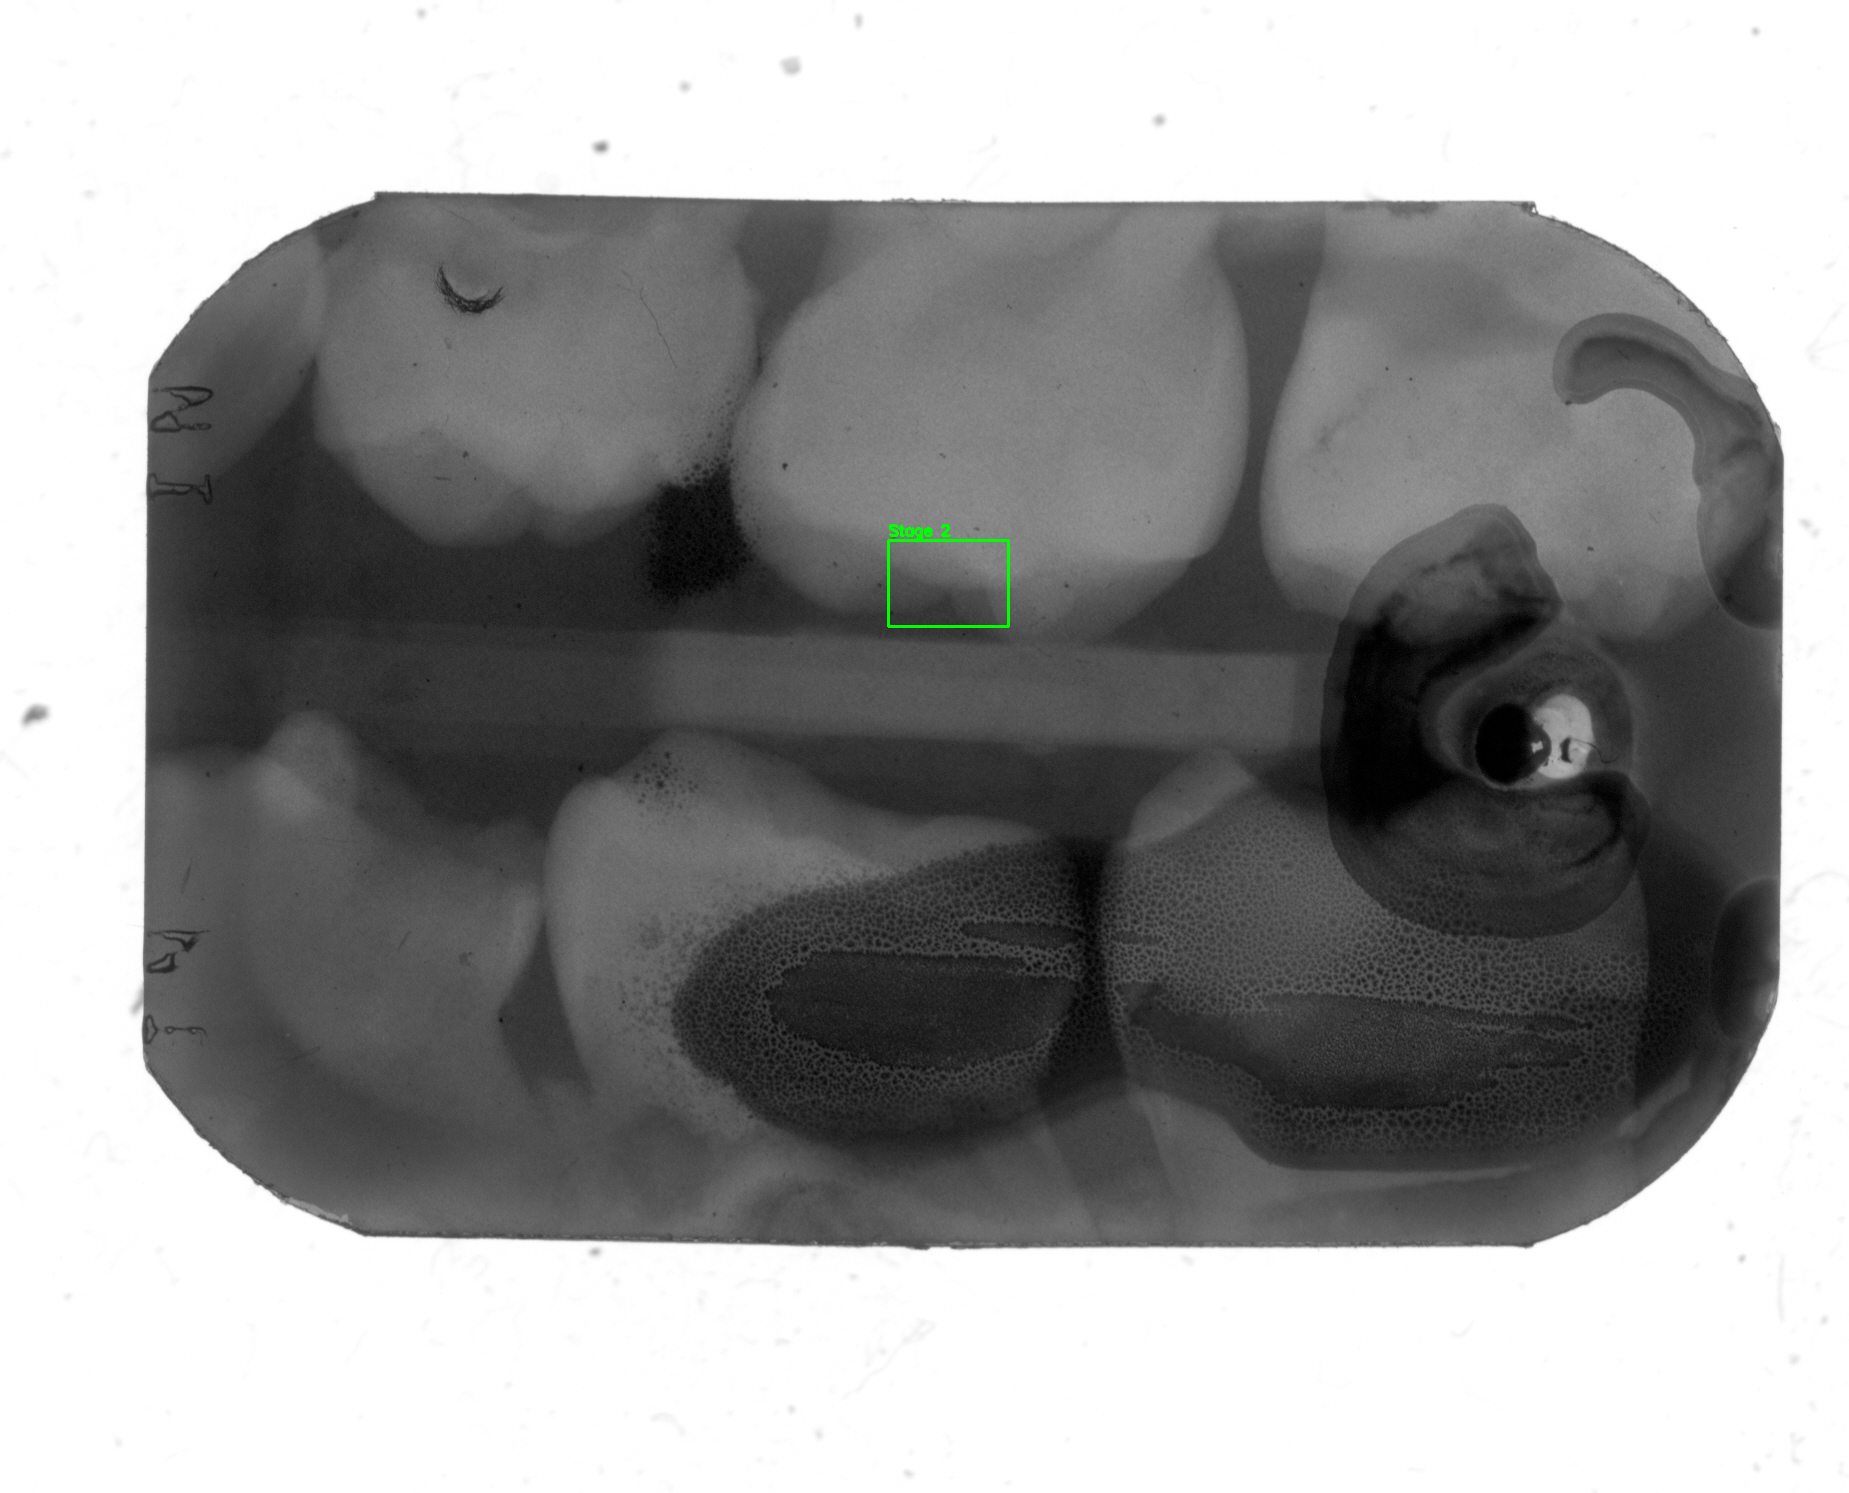

predicted image


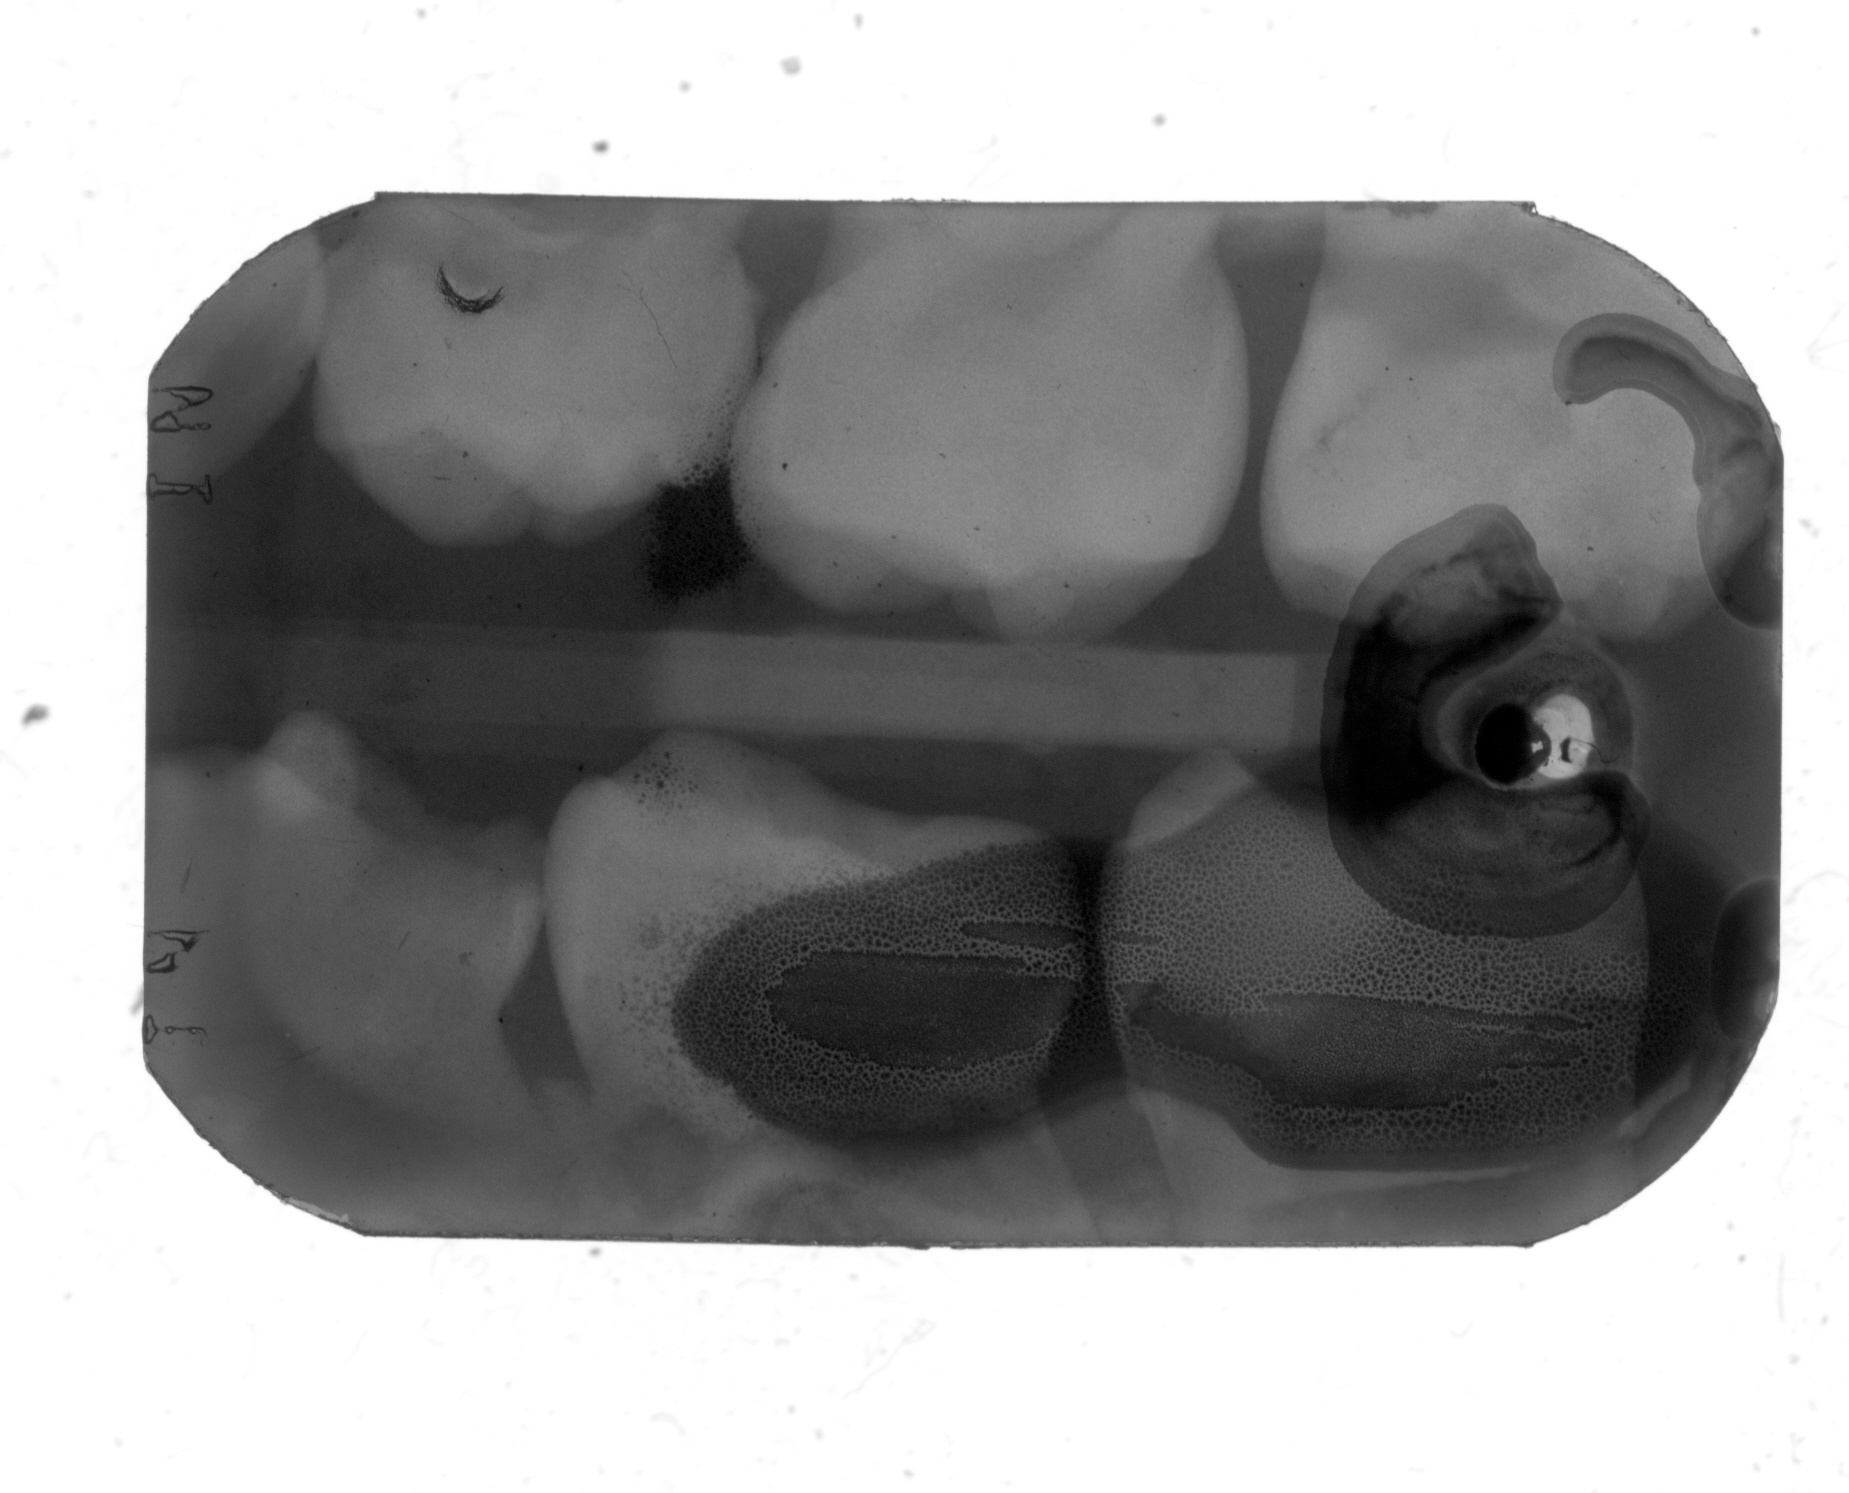

In [31]:

image = 'Image550'
img = cv2.imread(IMAGE_DIR + '\\val\\' + image + ".jpg")

# get bounding box positions
img_width, img_height = img.shape[1], img.shape[0]  # Get image width and height
with open(LABEL_DIR + "\\val\\" + image + ".txt", "r") as f:
    lines = f.readlines()
    bboxes = []
    for line in lines:
        print(line)
        class_id, norm_x_center, norm_y_center, norm_width, norm_height = map(float, line.split())

        class_id = int(class_id + 2)
        x_center = int(norm_x_center * img_width)
        y_center = int(norm_y_center * img_height)
        width = int(norm_width * img_width)
        height = int(norm_height * img_height)

        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        bbox = (x1, y1, x2, y2)
        bboxes.append((bbox, class_id))

# draw bounding boxes on image
for bbox, class_id in bboxes:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green boxes
    # Optionally, add class labels:
    cv2.putText(img, f"Stage {class_id}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

print("what the image should look like")
display(Image.fromarray(img))
# Save the image
target_dir = "runs\\inference\\initial\\correct_labels"
os.makedirs(target_dir, exist_ok=True)
cv2.imwrite(os.path.join(target_dir, image + ".jpg"), img)

# load the predicted image
img = cv2.imread('runs\\inference\\initial\\val\\' + image + ".jpg")
print("predicted image")
display(Image.fromarray(img))
